# Flir Tau2 Filters Modeling

The goal of the entire calibration process is to be able to predict how a captured scene would have looked if an IR filter was applied over the lense. This will enable us to generate artificial filtered images dataset (given a dataset of pan-chromatic images), which is required for the training of a hyper-spectral registration algorithm development.

Following the literature, we expect a linear model between the radiation flux (power) emitted from the scene and the obtained grey-levels:
$$ GL = \alpha P(T) + \beta + n$$
where $P(T)$ is the temperature-dependent radiation flux and $n$ is additive noise.

While this relationship is expected for the pan-chromatic case (without applying IR filters), we aren't sure what to expect in the filtered case.

By the end of the notebook, we wish to:

1. Validate the expected linear relationship between radiation flux and grey-levels in the pan-chromatic case.
2. Analyse and model the relationship in the filtered case.


## Packages and data imports:

In [ ]:
from tools import calc_rx_power, get_measurements, FilterWavelength, FilterWavelength, choose_random_pixels, calc_r2, c2k, k2c, find_parent_dir
from plots import showFacetImages, plot_rand_pix_regress
from regression import GlRegressor
import sys
from pathlib import Path
sys.path.append(str(Path().cwd().parent))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib widget


matplotlib.rcParams.update({'font.size': 14})

path_to_files = find_parent_dir("rawData") / 'calib' / 'tlinear_0'
path_to_models = find_parent_dir("models")


In [2]:
## Load panchromatic data:
meas_panchromatic, _, _, list_power_panchromatic, _, _ =\
    get_measurements(
        path_to_files, filter_wavelength=FilterWavelength.PAN, fast_load=True)


list_power_panchromatic = np.asarray(list_power_panchromatic)
gl_regressor = GlRegressor(is_parallel=True, x_label="L[W/m^2*rad]")


calculating power: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


In [7]:
# Auxiliary functions

def get_regression(re_run_regression, meas, independent_var, deg=1, feature_power=1, model_name=""):
    f_name = model_name + ".pkl"
    if re_run_regression:
        gl_regressor.fit(independent_var,
                         meas, deg=deg, feature_power=feature_power, debug=True)
        gl_regressor.save_model(path_to_models / f_name)
    else:
        gl_regressor.load_model(path_to_models / f_name)


def eval_fit(meas, independent_var, is_inverse=False):
    if not is_inverse:
        # eval fit:
        gl_hat = gl_regressor.predict(independent_var)
        ax_lbls = {"xlabel": "BB Radiance[W/m^2*rad]", "ylabel": "Grey-levels"}
        err_df = gl_regressor.eval(meas, gl_hat,
                                independent_var, debug=True, ax_lbls=ax_lbls)

    else:
        L_hat = gl_regressor.predict(meas, is_inverse=True)
        ax_lbls = {"xlabel": "BB Radiance[W/m^2*rad]",
                "ylabel": "Radiance Estimation Error"}
        err_df = gl_regressor.eval(independent_var, L_hat,
                                independent_var, debug=True, ax_lbls=ax_lbls)


## Model Validation

Recapping, in the pan-chromatic setup, we expect a linear model between the radiation flux (power) emitted from the scene and the obtained grey-levels:
$$ GL = \alpha P(T) + \beta + n$$

Let's put this model assumption to the test:

% TODO: complete the model validation

In [23]:
from tools import calc_r2
def plot_rand_pix_fit(x ,y, data_label, x_label, y_label):
    y_vis = y.flatten()
    x_vis = np.repeat(x, len(
        y_vis) // len(x))
    p = np.polyfit(x_vis, y_vis, deg=1)
    poly = np.poly1d(p)
    r_2 = calc_r2(poly(x_vis), y_vis)

    plt.scatter(x_vis, y_vis, label=f"{data_label} samples")
    plt.plot(x_vis, poly(x_vis), "--",
             label=fr"${y_label} = {p[0]:.2f} \times P + {p[1]:.2f} (R^2={r_2:.4f})$")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid()
    plt.legend()
    plt.title("Model Fitting")
    plt.tight_layout()

plt.figure()
i, j = choose_random_pixels(1, meas_panchromatic.shape[2:])

plot_rand_pix_fit(list_power_panchromatic,
                  meas_panchromatic[..., i, j], "pan-chromatic", "radiation flux", "GL")


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Indeed, it appears that the linear model is a good fit for the relationship between the radiation flux and the obtained grey-levels.

Now, let's fit the model for all the spatial pixels:

In [6]:
get_regression(False, meas_panchromatic,
               list_power_panchromatic, model_name="p2gl_lin")


In [8]:
eval_fit(meas_panchromatic, list_power_panchromatic)

Predicting: 100%|██████████| 86016/86016 [00:00<00:00, 94312.27it/s]


Predictions are ready!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Predicting: 100%|██████████| 86016/86016 [08:33<00:00, 167.46it/s]


Predictions are ready!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Filtered Data Analysis

The question remains whether the fitted model could also be used to predict the intensity levels of the scene when a LWIR filter is applied.

To do so, we will use the learned coefficients, and use them to predict the intensity levels based on the analytically calculated radiation flux that's typical to filter appliance. We will then compare the output of this model to actual images acquired with the real filters.

Just to get a feeling, let's try this on the 9micron filter and try to predict the image for 2 different operating-points:

In [4]:
meas_filt, _, _, list_power_filt, list_blackbody_temperatures, _ = get_measurements(
        path_to_files, filter_wavelength=FilterWavelength.nm9000, fast_load=True)


calculating power: 100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


Predicting: 100%|██████████| 86016/86016 [00:01<00:00, 79743.83it/s]


Predictions are ready!


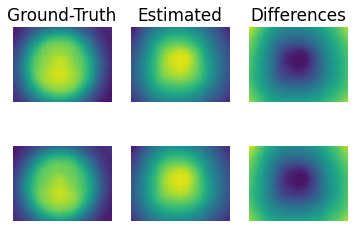

In [7]:

gl_hat_all = gl_regressor.predict(list_power_filt)

def plot_filt_vs_est(gl_est):
    target_power = list_power_filt[1], list_power_filt[-1]
    idx_list = [i for i, power in enumerate(list_power_filt) if power in target_power]
    gl_gt = meas_filt[idx_list].mean(axis=1)
    gl_hat = gl_est[idx_list]
    gl_diff = gl_gt - gl_hat
    fig, ax = plt.subplots(2,3)

    for i, (gt, hat, diff) in enumerate(zip(gl_gt, gl_hat, gl_diff)):
        ax[i, 0].imshow(gt)
        ax[i, 1].imshow(hat)
        ax[i, 2].imshow(diff)
        [axis.axis("off") for axis in ax[i]]
        ax[i, 0].set_ylabel(f"L={list_power_filt[idx_list[i]]}")
        if i==0:
            ax[i, 0].set_title("Ground-Truth")
            ax[i, 1].set_title("Estimated")
            ax[i, 2].set_title("Differences")

plot_filt_vs_est(gl_hat_all)


Carefully inspecting the differences profile, there seems to be a significant bias difference between the panchromatic model prediction and the filtered images intesities.

Let's see what happens when we compensate for the bias


added bias = 4066.2314544403243 GLs


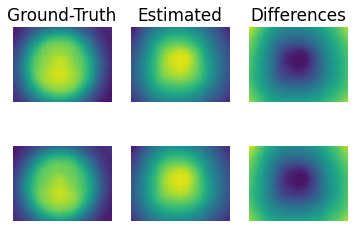

In [8]:
gl_diff_all = meas_filt.mean(axis=1) - gl_hat_all
gl_hat_all_unbiased = gl_hat_all + gl_diff_all.mean()
plot_filt_vs_est(gl_hat_all_unbiased)
print(f"added bias = {gl_diff_all.mean()} GLs")

While clearly better, the model fit for estimating the pan-chromatic grey-levels still isn't successful in predicting the filtered version. this might have to do with the black-body radiation of the filter itself.

Let's try and see whether a linear fit is even appropriate for the filtered case:

In [24]:
i, j = choose_random_pixels(1, meas_filt.shape[2:])

plt.figure()
plot_rand_pix_fit(list_power_panchromatic,
                  meas_panchromatic[..., i, j], "pan-chromatic", "radiation flux", "GL")
plot_rand_pix_fit(list_power_filt,
                  meas_filt[..., i, j], "filtered", "radiation flux", "GL")



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

We can see that:
1. While the SNR is much worse in the filtered case (because the dynamic range is very small ~400 grey-levels), there still seems to exist some linear relationship between the grey-levels and the radiation power.
2. Even after the bias correction, there seems to be a gap between the slopes of the pan-model and the filtered data. This suggests that we have generate a dedicated model for the filtered measurements.

Hence, we need to perform a separate regression to fit each of the filters:

In [5]:
power_filt = np.asarray(list_power_filt)
get_regression(False, meas_filt,
               power_filt, model_name="p2gl_filt_lin")


In [6]:
eval_fit(meas_filt, power_filt)


Predicting: 100%|██████████| 86016/86016 [00:00<00:00, 95426.55it/s] 


Predictions are ready!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Temperature fit

Instead of trying to linearly fit the grey levels to an analytically calculated power term, we can instead use the temperature to the power of 4, based on the same arguments that were applied for the pan-chromatic case. Ofcourse, as the filter attenuates the wavelengths outside its bandwidth, the slope (coefficient of $T^4$) is expected to be much smaller

In [8]:
blackbody_temperatures = np.asarray(list_blackbody_temperatures)

get_regression(False, meas_filt, c2k(blackbody_temperatures),
               feature_power=4, model_name="t2gl_filt_lin")


In [9]:
def eval_fit_temperature(meas, temperature, is_inverse=False):
    if not is_inverse:
        # eval fit:
        gl_hat = gl_regressor.predict(c2k(temperature))
        ax_lbls = {"xlabel": "Temperature[C]", "ylabel": "Grey-levels"}
        err_df = gl_regressor.eval(meas, gl_hat,
                                temperature, debug=True, ax_lbls=ax_lbls)
    else:
        L_hat = k2c(gl_regressor.predict(meas, is_inverse=True))
        ax_lbls = {"xlabel": "Temperature[C]",
                "ylabel": "Estimation Error"}
        err_df = gl_regressor.eval(temperature, L_hat,
                                temperature, debug=True, ax_lbls=ax_lbls)



In [10]:

eval_fit_temperature(meas_filt, blackbody_temperatures)


Predicting: 100%|██████████| 86016/86016 [00:00<00:00, 101431.13it/s]


Predictions are ready!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Interestingly, there's seemingly no difference in the estimation results of the power based model and the temperature based model, if at all - the results are slightly in favor of the power based model.

As the temperature Estimation itself is also of interest, we also want to look at the results of the inverse model:

In [11]:
eval_fit_temperature(meas_filt, blackbody_temperatures, is_inverse=True)


Predicting: 100%|██████████| 86016/86016 [10:22<00:00, 138.14it/s]


Predictions are ready!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

While not nearly as good an estimation as in the pan-chromatic case (which is expected, as the SNR is much worse in this case), roughly half of the measurements' estimation error is $<\frac{1}{2}$ degrees, and the vast majority is $<2$ degrees.

As the purpose of the filtered regression is for "forward" estimation of the grey levels, this isn't too significant, and we should pay more attention to the grey-level estimations results, which for the most part are satisfactory.

As the final step, we'll train a regression model per filter to be used later in the full pan -> filt transformation

In [12]:
for filt in FilterWavelength:
    if filt.value == 0: #pan
        continue
    print(f"Calibrating model for {filt.value} nm")
    meas_filt, _, _, list_power_filt, _, _ = get_measurements(
        path_to_files, filter_wavelength=filt, fast_load=True)

    power_filt = np.asarray(list_power_filt)
    get_regression(True, meas_filt, power_filt, model_name=f"p2gl_{filt.name}")



Calibrating model for 0 nm


calculating power: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Pre-Processing Variables For Regression...
Pre-Processing is Complete!
Performing the regression (this might take a few seconds/minutes, depending on the data size...)


Performing Regression: 100%|██████████| 86016/86016 [02:00<00:00, 714.52it/s]


Regression is complete!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Calibrating model for 8000 nm


calculating power: 100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


Pre-Processing Variables For Regression...
Pre-Processing is Complete!
Performing the regression (this might take a few seconds/minutes, depending on the data size...)


Performing Regression: 100%|██████████| 86016/86016 [01:56<00:00, 735.49it/s]


Regression is complete!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Calibrating model for 9000 nm


calculating power: 100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Pre-Processing Variables For Regression...
Pre-Processing is Complete!
Performing the regression (this might take a few seconds/minutes, depending on the data size...)


Performing Regression: 100%|██████████| 86016/86016 [01:51<00:00, 771.26it/s]


Regression is complete!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Calibrating model for 10000 nm


calculating power: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]


Pre-Processing Variables For Regression...
Pre-Processing is Complete!
Performing the regression (this might take a few seconds/minutes, depending on the data size...)


Performing Regression: 100%|██████████| 86016/86016 [01:48<00:00, 793.14it/s]


Regression is complete!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Calibrating model for 11000 nm


calculating power: 100%|██████████| 21/21 [00:12<00:00,  1.62it/s]


Pre-Processing Variables For Regression...
Pre-Processing is Complete!
Performing the regression (this might take a few seconds/minutes, depending on the data size...)


Performing Regression: 100%|██████████| 86016/86016 [01:47<00:00, 797.97it/s]


Regression is complete!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Calibrating model for 12000 nm


calculating power: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]


Pre-Processing Variables For Regression...
Pre-Processing is Complete!
Performing the regression (this might take a few seconds/minutes, depending on the data size...)


Performing Regression: 100%|██████████| 86016/86016 [01:48<00:00, 791.16it/s]


Regression is complete!


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …